<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [Global Ligand Docking using `XMLObjects` Using the `ref2015.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.01-Ligand-Docking-XMLObjects.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Working With Symmetry](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/10.00-Working-With-Symmetry.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.02-Ligand-Docking-pyrosetta.distributed.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# `GALigandDock` Protocol with `pyrosetta.distributed` Using the `beta_cart.wts` Scorefunction

*Warning*: This notebook uses `pyrosetta.distributed.viewer` code, which runs in `jupyter notebook` and might not run if you're using `jupyterlab`.

*Note:* This Jupyter notebook requires the PyRosetta distributed layer. Please make sure to activate the `PyRosetta.notebooks` conda environment before running this notebook. The kernel is set to use this environment. 

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
%matplotlib inline
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed
import pyrosetta.distributed.io as io
import pyrosetta.distributed.viewer as viewer
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import seaborn
seaborn.set()
import sys

# Notebook setup
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

Load the `TPA.am1-bcc.gp.params` file when using the `-beta_cart` flag, which has `gen_potential` atom typing and AM1-BCC partial charges:

In [2]:
pdb_filename = "inputs/test_lig.pdb"
ligand_params = "inputs/TPA.am1-bcc.gp.params"
flags = f"""
-ignore_unrecognized_res 1
-extra_res_fa {ligand_params}
-beta_cart
-out:level 200
"""
pyrosetta.distributed.init(flags)
pose_obj = io.pose_from_file(filename=pdb_filename)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-ignore_unrecognized_res 1 -extra_res_fa inputs/TPA.am1-bcc.gp.params -beta_cart -out:level 200', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /mnt/home/klimaj/git/Rosetta/main/source/src/python/PyRosetta/src/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.conda.linux.CentOS.python36.Release 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
INFO:rosetta:core.init.score_function_corrections: {0} [ WARNING ] Flag -beta_nov16 is set but -weights are also specified.  Not changing input weights file!
INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] TPA337 has an unfavorable ring conformation; the coordinates for this input structure may have b

Now we change the scorefunction in our RosettaScripts script to `beta_cart.wts`, the weights of which were optimized on protein-ligand complexes using ligands with AM1-BCC partial charges generated with Amber's `antechamber`.

`GALigandDock` within RosettaScripts normally outputs multiple `.pdb` files to disk if run by the command line. However, when using the `MultioutputRosettaScriptsTask` function in `pyrosetta.distributed`, the outputs will be captured in memory within this Jupyter session!

In [4]:
xml = f"""
<ROSETTASCRIPTS>
  <SCOREFXNS>
    <ScoreFunction name="fa_standard" weights="beta_cart.wts"/>
  </SCOREFXNS>
  <MOVERS>
    <GALigandDock name="dock"
                  scorefxn="fa_standard"
                  scorefxn_relax="fa_standard"
                  grid_step="0.25"
                  padding="5.0"
                  hashsize="8.0"
                  subhash="3"
                  nativepdb="{pdb_filename}"
                  final_exact_minimize="sc"
                  random_oversample="10"
                  rotprob="0.9"
                  rotEcut="100"
                  sidechains="auto"
                  initial_pool="{pdb_filename}">
      <Stage repeats="10" npool="50" pmut="0.2" smoothing="0.375" rmsdthreshold="2.5" maxiter="50" pack_cycles="100" ramp_schedule="0.1,1.0"/>
      <Stage repeats="10" npool="50" pmut="0.2" smoothing="0.375" rmsdthreshold="1.5" maxiter="50" pack_cycles="100" ramp_schedule="0.1,1.0"/>
    </GALigandDock>
  </MOVERS>
  <PROTOCOLS>
    <Add mover="dock"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
"""
xml_obj = rosetta_scripts.MultioutputRosettaScriptsTask(xml)
xml_obj.setup()

INFO:rosetta:core.io.pose_from_sfr.PoseFromSFRBuilder: {0} [ WARNING ] TPA337 has an unfavorable ring conformation; the coordinates for this input structure may have been poorly assigned.


`MultioutputRosettaScriptsTask` is a python generator object. Therefore, we need to call `list()` or `set()` on it to run it.

*Warning*, the following cell runs for ~45 minutes CPU time.

In [6]:
if not os.getenv("DEBUG"):
    %time results = list(xml_obj(pose_obj))

### Inspect the scores for the `GALigandDock` trajectories:

In [5]:
if not os.getenv("DEBUG"):
    df = pd.DataFrame.from_records(packed_pose.to_dict(results))
    df

,cart_bonded,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,omega,p_aa_pp,pickled_pose,rama_prepro,ref,total_score
0,1123.712502,0.0,-2151.762324,2073.947599,351.670653,526.462836,-608.942522,-152.925958,-91.709467,484.474982,...,914.974515,8.028863,56.938398,2237.073939,3.205810,-84.787860,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,338.665837,-83.04488,2146.657901
1,1126.994362,0.0,-2153.494398,2074.354803,350.045712,527.638427,-598.326113,-155.611156,-95.374631,487.259466,...,912.676585,8.185741,57.137773,2236.078391,2.616802,-84.905751,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,338.066308,-83.04488,2154.465790
2,1122.218749,0.0,-2152.061341,2074.616276,352.358914,528.828818,-592.915774,-152.872453,-94.779139,484.857347,...,911.937969,8.482099,59.081443,2234.873025,2.785344,-84.712778,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,338.017765,-83.04488,2160.068530
3,1124.089966,0.0,-2152.510428,2074.255528,352.854664,526.668672,-594.728864,-154.667979,-91.274751,484.674904,...,911.669956,8.161121,56.862517,2235.493136,2.689288,-84.570622,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,338.948903,-83.04488,2168.046714
4,1127.329477,0.0,-2144.634818,2074.065162,353.115713,528.590003,-591.697767,-157.057321,-99.639525,488.113252,...,911.687657,8.390250,59.421205,2230.112093,3.098268,-84.642988,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,339.732965,-83.04488,2171.305626
5,1119.868142,0.0,-2135.739776,2073.996665,353.098796,528.725083,-585.912100,-153.333212,-95.675236,484.059834,...,904.758285,8.352889,59.583429,2222.677958,2.782730,-84.397516,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,339.262489,-83.04488,2174.354305
6,1119.054847,0.0,-2128.180817,2074.125675,354.267620,527.658626,-600.190559,-152.753968,-93.492140,484.075625,...,910.301829,8.267338,58.256741,2225.289996,2.463544,-83.967544,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,340.339600,-83.04488,2175.892215
7,1118.147392,0.0,-2120.681500,2073.846102,354.157516,527.871629,-589.804841,-153.593008,-94.975244,485.339630,...,901.078625,8.301181,57.906715,2210.271834,2.188813,-84.127671,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,340.763695,-83.04488,2176.467254
8,1117.748559,0.0,-2123.042805,2074.240598,354.436350,528.611581,-590.876958,-153.665083,-94.331011,485.674473,...,902.906292,8.220858,58.551026,2216.794578,2.357257,-84.155674,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,339.664206,-83.04488,2176.841510
9,1122.056963,0.0,-2148.039319,2074.745640,352.344596,529.868373,-594.182910,-153.210177,-92.399237,484.908058,...,914.566198,7.920984,55.527792,2237.359424,2.137919,-84.688511,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,339.407441,-83.04488,2176.972496


### Now that we have performed `GALigandDock`, we can plot the ligand binding energy landscape:

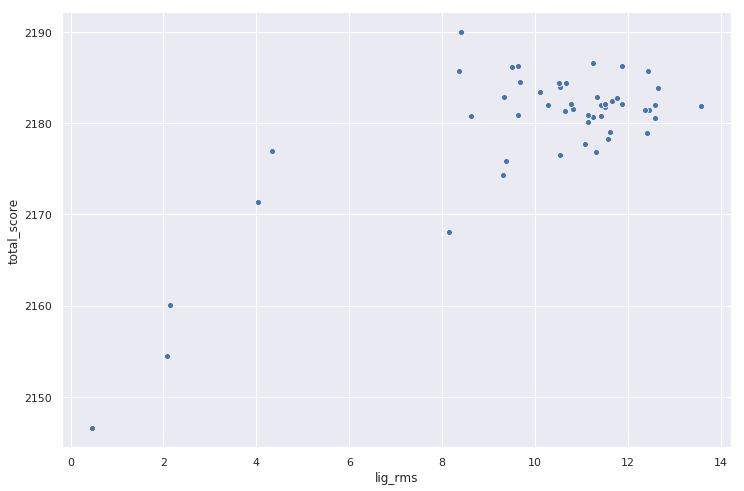

In [6]:
if not os.getenv("DEBUG"):
    matplotlib.rcParams["figure.figsize"] = [12.0, 8.0]
    seaborn.scatterplot(x="lig_rms", y="total_score", data=df)

Let's look at the ligand dock with the lowest `total_score` score!

In [7]:
if not os.getenv("DEBUG"):
    ppose_lowest_total_score = results[df.sort_values(by="total_score").index[0]]
    view = viewer.init(ppose_lowest_total_score)
    view.add(viewer.setStyle())
    view.add(viewer.setStyle(command=({"hetflag": True}, {"stick": {"colorscheme": "brownCarbon", "radius": 0.2}})))
    view.add(viewer.setSurface(residue_selector=pyrosetta.rosetta.core.select.residue_selector.ChainSelector("E"), opacity=0.7, color='white'))
    view.add(viewer.setHydrogenBonds())
    view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<!--NAVIGATION-->
< [Global Ligand Docking using `XMLObjects` Using the `ref2015.wts` Scorefunction](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.01-Ligand-Docking-XMLObjects.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Working With Symmetry](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/10.00-Working-With-Symmetry.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/08.02-Ligand-Docking-pyrosetta.distributed.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>